In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima



In [22]:
df=pd.read_csv('Kiriwaneliya_project.csv')
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [23]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)

In [24]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-January
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-February
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-March
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-April
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-May


In [25]:
hum_min=df[["Time","Hum_min"]]
hum_min.head()

,Time,Hum_min
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [26]:
hum_min['Time']=pd.to_datetime(hum_min['Time'])


C:\Users\wasan\AppData\Local\Temp/ipykernel_14884/3648415634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_min['Time']=pd.to_datetime(hum_min['Time'])


In [27]:
hum_min.head()

,Time,Hum_min
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [28]:
#Checking for missing values
hum_min.isna().sum()


Time        0
Hum_min    14
dtype: int64

In [29]:
#Setting the time index
hum_min.set_index('Time',inplace=True)

In [30]:
hum_min=hum_min.resample('MS').first()

In [31]:
#filling missing values
hum=hum_min.fillna(method="bfill")
hum.head()

,Hum_min
Time,
2010-01-01,83.0
2010-02-01,83.0
2010-03-01,83.0
2010-04-01,83.0
2010-05-01,83.0


In [32]:
hum = hum.rename(columns = {'Hum_min': 'Humidity'})
hum.head()

,Humidity
Time,
2010-01-01,83.0
2010-02-01,83.0
2010-03-01,83.0
2010-04-01,83.0
2010-05-01,83.0


In [33]:
hum.columns

Index(['Humidity'], dtype='object')

<AxesSubplot:xlabel='Time'>

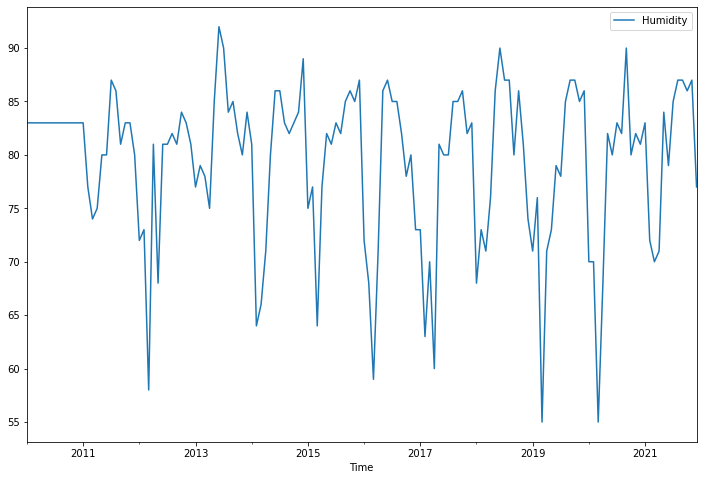

In [34]:
hum.plot(figsize=(12,8))

No trend. But some evidence for seasonality

# Testing For Stationarity

In [35]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])


ADF Test Statistic : -3.388690992646288
p-value : 0.011350489566870908
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [36]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])

KPSS Statistic: 0.1784292616401315
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [37]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.537
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

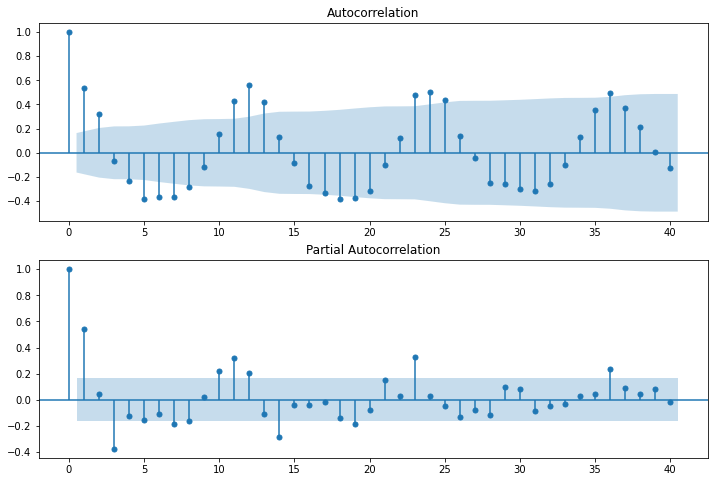

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)

According to the PACF and ACF plots it's better to start with p=3, d=0, q=2

In [47]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_d=0,start_q=0,max_p=3,max_D=1,max_q=2,start_P=0,start_D=0,start_Q=0,max_P=3,max_Q=2,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=80,maxiter=70)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=984.549, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=953.926, Time=0.09 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=942.585, Time=0.27 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=931.730, Time=0.40 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=904.918, Time=0.66 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=928.997, Time=1.47 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=917.189, Time=1.11 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=943.448, Time=1.76 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=954.857, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=935.041, Time=0.14 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=932.125, Time=0.36 sec
 ARIMA(0,0,1)(1,0,0)[12] i

In [48]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(0, 0, 2),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Humidity   No. Observations:                  144
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -465.244
Date:                              Tue, 26 Apr 2022   AIC                            940.489
Time:                                      02:04:02   BIC                            955.338
Sample:                                  01-01-2010   HQIC                           946.522
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1920      0.076      2.542      0.011       0.044       0.340
ma.L2          0.3682      0.077      4.790      0.000       0.218       0.519
ar.S.L12       0.9997      0.000   2705.226      0.000       0.999       1.000
ma.S.L12      -0.7638      0.086     -8.903      0.000      -0.932      -0.596
sigma2        23.5668      2.629      8.964      0.000      18.414      28.719
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                10.25
Prob(Q):                              0.51   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                            -0.57
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
beg_dt='2017-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

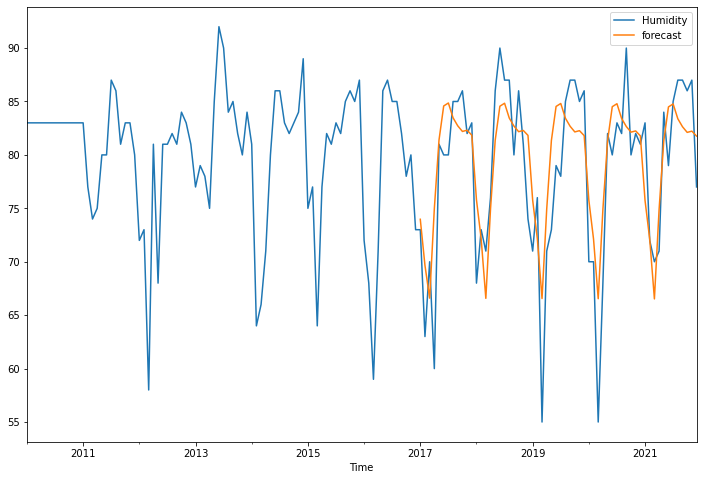

In [50]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))

In [42]:
hum.tail()

,Humidity,forecast
Time,,
2021-08-01,87.0,48.912524
2021-09-01,87.0,48.379576
2021-10-01,86.0,47.389335
2021-11-01,87.0,47.521303
2021-12-01,77.0,46.006454
